# Investigating relationships between gun transactions and census metrics
*An investigation of the FBI's National Instant Criminal Background Check System (NICS) usage as a proxy for firearms transactions and how statewide gun transactions relate to a state census metrics relating to education, income, affluence, and other factors*

Research project performed by William J Townsend for Udacity's Data Analysis NanoDegree Program
13 Aug 2021

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#question1">Q1: How do population and population change impact firearms transactions?</a></li>
<li><a href="#aside">Aside: Kentucky, Illinois, and NICS Permit Data</a></li> 
<li><a href="#question1part2">Q1: Population Change Part 2</a></li> 
<li><a href="#question2">Q2: How do other societal metrics impact firearms transactions?  </a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

The FBI's **N**ational **I**nstant **C**riminal Background Check **S**ystem (NICS) program is used to determine if potential buyers are eligible to purchase firearms or explosives. This data is [published by the FBI for public consumption](https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view), providing information for all 50 states with regard to the number of NICS checks completed on a monthly basis for a variety of purposes. 

This data comes from NICS checks performed for a variety of firearms transactions, including purchases of a firearm from authorized sellers, "pre-pawn" of a firearm (placed as a security against a debt or payment at a pawn shop), private sales of firearms, firearms rentals, returns, and other transactions.  Each type of transaction is used as a category, which is further broken down by whether the firearm at issue was a handgun, long gun, or "other" (specific types of firearms or certain firearms parts & accessories, such as silencers or parts to build a gun).  This data also includes checks performed for a variety of reasons such as purchase of certain permits (e.g. concealed weapons permits) and rechecks of existing permit holders to verify continued eligibility for such permits.  

The FBI stipulates that this data is not a perfect 1:1 indicator of firearms transactions due to a variety of factors.  While it may not be a perfect representation of firearms transactions in the United States, I intend to use this data as a representation of a majority of those transactions, and related trends. That data can then be examined against metrics from the U.S. Census, allowing for examination of how measures like income, veteran status, affluence, and education relate to firearms transactions. With all of this, I intend to use this data to look for answers to two questions:

- How do population and population change impact firearms transactions?
- How do other societal and demographic statistics impact firearms transactions? Are any of these relationships stronger than those seen for population?

Two prepared datasets were used for this project, both provided by Udacity: [FBI NICS data (Sep 2017)](https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a5623_ncis-and-census-data/ncis-and-census-data.zip&sa=D&source=editors&ust=1628548377350000&usg=AOvVaw3G_pdCV0PpmfvAk93FQFEJ) & [US Census Data (2016)](https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/November/5a0a554c_u.s.-census-data/u.s.-census-data.csv&sa=D&source=editors&ust=1628548377353000&usg=AOvVaw35-p6PdzWwvoQThyamxfhU)

In [1]:
#Importing packages to be used in the scripts for this analysis:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

Before we can begin exploring our data, we first have to get our data placed into a format that is easy to use and manipulate. We'll start by generating two pandas DataFrames: `df_guns` and `df_census`. 

In [2]:
df_guns = pd.read_excel('gun_data.xlsx') # FBI data was in an .xlsx file, rather than CSV
df_census = pd.read_csv('U.S. Census Data.csv')

In [3]:
df_guns.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [4]:
df_guns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   month                      12485 non-null  object 
 1   state                      12485 non-null  object 
 2   permit                     12461 non-null  float64
 3   permit_recheck             1100 non-null   float64
 4   handgun                    12465 non-null  float64
 5   long_gun                   12466 non-null  float64
 6   other                      5500 non-null   float64
 7   multiple                   12485 non-null  int64  
 8   admin                      12462 non-null  float64
 9   prepawn_handgun            10542 non-null  float64
 10  prepawn_long_gun           10540 non-null  float64
 11  prepawn_other              5115 non-null   float64
 12  redemption_handgun         10545 non-null  float64
 13  redemption_long_gun        10544 non-null  flo

This dataset actually runs from Nov 1998 to Sep 2017, over 12,000 rows, though it has expanded significantly over that time.  As our census data only has records from 2010 and 2016, we'll need to drop most of this data.  Each measurement is broken into year-month-state, and while I could compare a particular year-month combo from 2016/2010 to the census data, the NICS data is subject to [very strong month-to-month variation](https://github.com/BuzzFeedNews/nics-firearm-background-checks/blob/master/charts/total-checks-36-months.png), generally spiking in Nov/Dec, dropping precipitously in Jan/Feb, and then spiking even higher in Mar before dwindling until the next autumn. As a result, I intend to aggregate each year's data to get monthly averages for all 50 states, which may be compared against the census data for all 50 states.  Regarding the datatypes here, this dataset is pretty well formatted, without any columns cast as an inappropriate datatype.  The year-month column being a string object is actually not a problem here, as I can easily groupby a string rather than date or datetime.  

In [5]:
df_guns['month'] = df_guns['month'].str[:4] # Modify year-month values to only year (first 4 characters)
df_guns = df_guns.query('month == "2016" | month == "2010"') # Update dataframe with only 2010 & 2016 data
df_guns.rename(columns={'month' : 'year'}, inplace=True) # Update column name

In [6]:
df_guns.isna().sum() # Check remaining data for NaN values

year                            0
state                           0
permit                          0
permit_recheck                715
handgun                         0
long_gun                        0
other                           0
multiple                        0
admin                           0
prepawn_handgun                 0
prepawn_long_gun                0
prepawn_other                   0
redemption_handgun              0
redemption_long_gun             0
redemption_other                0
returned_handgun              660
returned_long_gun             660
returned_other                660
rentals_handgun              1045
rentals_long_gun             1045
private_sale_handgun          660
private_sale_long_gun         660
private_sale_other            660
return_to_seller_handgun      660
return_to_seller_long_gun     660
return_to_seller_other        660
totals                          0
dtype: int64

We can see that we have a lot of `NaN` values left over after isolating the years that we're interested in.  Looking through the FBI's published reports on this data, many of these columns were not tracked in 2010, though all are being tracked by 2016.  Getting rid of these columns would eliminate tracked data for 2016, and there is no nearby data to generate an estimate to fill in those columns.  As a result, I chose to simply fill in the untracked `NaN` values from 2010 with 0.

In [7]:
df_guns.fillna(0, inplace=True)

As I am not interested in how many transactions happen by certain means and am only focused on the sum of transactions, I'm going to combine the various 'handgun', 'long_gun', and 'other' fields across the table. This should represent all NICS checked transactions for each of these types of firearms.

The 'permit_recheck' column will be dropped from this data.  According to the FBI's documentation, some states do not recheck current permit holders, while some states recheck a portion of all permits monthly.  This means that it is not an indication of what is happening currently but instead an indication of what has happened cumulatively, which is not relevant to this study. 

For the sake of simplicity, I'm going to combine the other remaining columns, aside from permit rechecks.  These are 'multiple', 'admin', and 'permit'.  The 'multiple' column indicates transactions of multiple firearms, so this is definitely indicative of a firearms transaction that I want to track.  The 'admin' column is not consistently used, so its inclusion seems unlikely to matter one way or another.  The inclusion of 'permits' was one that I wrestled with, but I ultimately settled on retaining the data.  This is because while permits may not necessarily indicate a purchase/sale of a firearm, the purchasing of firearms-related permits is often associated with a transaction and it certainly speaks to a "popularity" element of firearms, which I believe to be consistent with my goal of examining how guns and social metrics relate to each other.  

In [8]:
df_guns.insert(loc=2, column='all_others', value=df_guns['other'] + df_guns['prepawn_other'] + df_guns['redemption_other'] + df_guns['returned_other']+ df_guns['private_sale_other'] + df_guns['return_to_seller_other'])
df_guns.insert(loc=2, column='all_long_guns', value=df_guns['long_gun'] + df_guns['prepawn_long_gun'] + df_guns['redemption_long_gun'] + df_guns['returned_long_gun'] + df_guns['rentals_long_gun'] + df_guns['private_sale_long_gun'] + df_guns['return_to_seller_long_gun'])
df_guns.insert(loc=2, column='all_handguns', value=df_guns['handgun'] + df_guns['prepawn_handgun'] + df_guns['redemption_handgun'] + df_guns['returned_handgun'] + df_guns['rentals_handgun'] + df_guns['private_sale_handgun'] + df_guns['return_to_seller_handgun'])
df_guns.insert(loc=2, column='new_permits', value=df_guns['permit'] + df_guns['multiple'] + df_guns['admin'])

In [9]:
df_guns.drop(df_guns.iloc[:, 6:], axis=1, inplace=True) # Dropping the columns that we just combined into 4 columns

In [10]:
df_guns.head(10)

,year,state,new_permits,all_handguns,all_long_guns,all_others
495,2016,Alabama,27529.0,15118.0,18987.0,380.0
496,2016,Alaska,445.0,4284.0,3812.0,245.0
497,2016,Arizona,9603.0,19509.0,14471.0,1183.0
498,2016,Arkansas,3716.0,10232.0,15006.0,280.0
499,2016,California,61808.0,64290.0,94055.0,78008.0
500,2016,Colorado,6759.0,26060.0,21181.0,1428.0
501,2016,Connecticut,6549.0,8003.0,3154.0,119.0
502,2016,Delaware,437.0,2759.0,3027.0,133.0
503,2016,District of Columbia,6.0,60.0,5.0,0.0
504,2016,Florida,26691.0,73488.0,41305.0,3499.0


As we can see, the FBI data also includes 5 extra 'states' for each month: Washington D.C., Puerto Rico, Guam, Mariana Islands, and the Virgin Islands.  As there is not census data for this regions, we'll remove those rows as well.  

In [11]:
not_states = ['Virgin Islands', 'Puerto Rico', 'Mariana Islands', 'Guam', 'District of Columbia']
df_guns = df_guns[~df_guns.state.isin(not_states)] # Using ~ to reverse isin(), functions like a NOT IN

With the dataframe organized, the `df_guns` dataframe needs to be broken up into a dataframe with 2010 NICS data and another with 2016 NICS data. Once separated, the data for the entire year can be aggregated into an average value for each column, by state. 

In [12]:
pull_2010 = df_guns.query('year == "2010"')
pull_2016 = df_guns.query('year == "2016"')

In [13]:
guns_2010 = pull_2010.groupby(['state']).agg({'new_permits': np.mean, 'all_handguns': np.mean, 'all_long_guns': np.mean, 'all_others' : np.mean})
guns_2016 = pull_2016.groupby(['state']).agg({'new_permits': np.mean, 'all_handguns': np.mean, 'all_long_guns': np.mean, 'all_others' : np.mean})

guns_2010.head(1)

A 'total' column would also be useful for both dataframes, summing the total number of NICS checks for each state. It will be cast as an integer, as there is not a fraction of a NICS check or transaction.   

In [14]:
guns_2010.insert(loc=0, column='total', value= guns_2010['new_permits'] + guns_2010['all_handguns'] + guns_2010['all_long_guns'] + guns_2010['all_others'])
guns_2010['total'] = guns_2010['total'].astype(int)

In [15]:
guns_2010.head(3)

,total,new_permits,all_handguns,all_long_guns,all_others
state,,,,,
Alabama,25717,842.083333,11387.666667,13336.916667,150.583333
Alaska,5492,126.583333,2322.500000,2974.333333,69.000000
Arizona,17170,2376.583333,8294.083333,6324.833333,175.333333


In [16]:
guns_2016.insert(loc=0, column='total', value= guns_2016['new_permits'] + guns_2016['all_handguns'] + guns_2016['all_long_guns'] + guns_2016['all_others'])
guns_2016['total'] = guns_2016['total'].astype(int)

In [17]:
guns_2016.head(1)

,total,new_permits,all_handguns,all_long_guns,all_others
state,,,,,
Alabama,51412,24799.083333,14445.416667,11653.416667,514.333333


There is no 2010 census data to compare directly against the 2010 FBI data, but there is census data indicating changes from 2010 to 2016.  Comparison to this data would require information about how the FBI data has changed from 2010 to 2016.  This can be easily created now that the FBI data is broken into pieces for 2010 and 2016.  

In [18]:
headers = ["total_2010", "total_2016"]
guns_diff = pd.concat([guns_2010['total'], guns_2016['total']], axis=1, keys=headers)
guns_diff['guns_pct_diff'] = ((guns_diff['total_2016'] - guns_diff['total_2010']) / guns_diff['total_2010']) * 100

In [19]:
guns_diff.head()

,total_2010,total_2016,guns_pct_diff
state,,,
Alabama,25717,51412,99.914453
Alaska,5492,7303,32.975237
Arizona,17170,34264,99.557368
Arkansas,15954,21581,35.270152
California,68033,198097,191.177811


With FBI data for 2016 to compare to 2016 census data, and FBI data demonstrating changes from 2010 - 2016 to compare to similar census data, the census data now needs to be wrangled so that it can be joined with that FBI data for analysis. Recall that the census data was loaded into the `df_census` dataframe.

In [20]:
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


This data is clearly very poorly formatted for the purposes of data analysis.  The intent is to be able to easily compare from state to state, and having columns with different types of data in them is not going to work well for performing functions, visualizing data, etc.  Transposing the dataframe will flip the dataframe on the diagonal axis, so that states become rows rather than columns, and each metric becomes a column.  

In [21]:
df_census = df_census.transpose()

In [22]:
df_census.head()

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2...","Population, percent change - April 1, 2010 (es...","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, ...","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016,...","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2...","Persons 65 years and over, percent, April 1, 2010",...,NaN,Value Flags,-,D,F,FN,NaN,S,X,Z
Fact Note,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Either no or too few sample observations were ...,Suppressed to avoid disclosure of confidential...,Fewer than 25 firms,Footnote on this item in place of data,Not available,Suppressed; does not meet publication standards,Not applicable,Value greater than zero but less than half uni...
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The index of rows became the column titles, so I'll turn the top row into the column names, provide a name to the index, and then delete 'Fact and 'Fact Note' columns. Then I'll update the dataframe to only have the columns for census metrics which I'm interested in.  

In [23]:
df_census.rename(columns=df_census.iloc[0], inplace=True) # Replace column labels with the values in the top row
df_census.drop(['Fact', 'Fact Note'], axis=0, inplace=True) # Drop the top two rows
df_census.index.name = 'state' # Give index a name, allows reference to the index later on
df_census = df_census[df_census.columns[[1, 0, 2, 20, 25, 28, 29, 34, 35, 47, 49, 62]]] # Update dataframe to only these columns

In [24]:
df_census.head(1)

,"Population estimates base, April 1, 2010, (V2016)","Population estimates, July 1, 2016, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Veterans, 2011-2015","Median value of owner-occupied housing units, 2011-2015","Median gross rent, 2011-2015","Building permits, 2016","High school graduate or higher, percent of persons age 25 years+, 2011-2015","Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015","Median household income (in 2015 dollars), 2011-2015","Persons in poverty, percent","Population per square mile, 2010"
state,,,,,,,,,,,,
Alabama,"4,780,131","4,863,300",1.70%,"363,170","$125,500",$717,"15,001",84.30%,23.50%,"$43,623",17.10%,94.4


These column names are extremely verbose, so I'll update them to be more Pythonic.

In [25]:
new_cols = ['pop_2010', 'pop_2016', 'pop_pct_diff', 'veterans', 'median_value_housing', 'median_rent', 'building_permits', 'hs_graduates_25+', 'bach_graduates_25+', 'median_household_income', 'poverty_rate', 'pop_per_sq_mile']
df_census.columns=new_cols

In [26]:
df_census.head(1)

,pop_2010,pop_2016,pop_pct_diff,veterans,median_value_housing,median_rent,building_permits,hs_graduates_25+,bach_graduates_25+,median_household_income,poverty_rate,pop_per_sq_mile
state,,,,,,,,,,,,
Alabama,"4,780,131","4,863,300",1.70%,"363,170","$125,500",$717,"15,001",84.30%,23.50%,"$43,623",17.10%,94.4


The columns chosen out of the census data are:
- 'pop_2010' = Total population estimate (Jul 1 2016)
- 'pop_2016' = Total population estimate (Apr 1 2010)
- 'pop_pct_diff' = Percentage change in population from pop_2010 to pop_2016
- 'veterans' = Total number of veterans in population
- 'median_value_housing' = Median value of owner-occupied housing units
- 'median_rent' = Median gross rent price
- 'building_permits' = Number of issued building permits
- 'hs_graduates_25+' = Persons age 25+ graduated from high school
- 'bach_graduates_25+' = Person's age 25+ graduated with Bachelor's degree
- 'median_household_income' = Median household income 
- 'poverty_rate' = Percentage of population in poverty
- 'pop_per_sq_mile' = Population per square mile land area

These columns were selected because of the implications they make towards a state's education, veteran population, average income, or statewide measures of affluence and prosperity. The population columns were chosen to examine the relationship between a state's population and its number of NICS checks, as an indication of firearms transactions. Expecting a strong relationship between population and NICS checks (more people in a state means more people using a service), the goal is to account for the impact of population growth on NICS checks, so that this impact can be compared to other indicators here which may be stronger or weaker.  

In [27]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   pop_2010                 50 non-null     object
 1   pop_2016                 50 non-null     object
 2   pop_pct_diff             50 non-null     object
 3   veterans                 50 non-null     object
 4   median_value_housing     50 non-null     object
 5   median_rent              50 non-null     object
 6   building_permits         50 non-null     object
 7   hs_graduates_25+         50 non-null     object
 8   bach_graduates_25+       50 non-null     object
 9   median_household_income  50 non-null     object
 10  poverty_rate             50 non-null     object
 11  pop_per_sq_mile          50 non-null     object
dtypes: object(12)
memory usage: 5.1+ KB


This census data still has significant problems that prevent it from being analyzed easily, though it has been at least isolated down to only the data of interest to this study.  All data is stored as a string here, rather than as integers or floats, and any attempt to use `astype()` to cast a column as a different dtype will fail because the data is not consistent within each column.  

In [28]:
df_census.loc[['Alabama', 'Ohio']]

,pop_2010,pop_2016,pop_pct_diff,veterans,median_value_housing,median_rent,building_permits,hs_graduates_25+,bach_graduates_25+,median_household_income,poverty_rate,pop_per_sq_mile
state,,,,,,,,,,,,
Alabama,"4,780,131","4,863,300",1.70%,"363,170","$125,500",$717,"15,001",84.30%,23.50%,"$43,623",17.10%,94.4
Ohio,11536727,11614373,0.007,806531,129900,730,22816,0.891,0.261,49429,0.146,282.3


Specifically, there's 12 states' data in the middle of the dataframe which is inconsistent with the data above and below, having no formatting at all while the other 38 states have spreadsheet-type formatting: comma separators, proportions converted to percentages (multiplied by 100 and '%' appended), and financial data prefixed with '$'.  These issues impact each column in the dataframe.  The percentage issue in particular is problematic, as some values need to be multiplied by 100 to be comparable to the other values in the column, while other values need to be stripped of non-numeric characters.  

This makes fixing the percentage columns a bit tricky because fixing them involves identifying *which* problem exists in that particular cell and then using the appropriate operation. After creating a list of all percentage columns needing modified, a mask can be used to identify all values containing '\%'. Rows in that column which do have a '\%' will then be stripped and converted to float. Rows which were not included in that (did not contain '\%') will instead be multiplied by 100 and converted to float. 

In [29]:
# List columns needing fixed
pct_columns = ['pop_pct_diff', 'poverty_rate', 'bach_graduates_25+', 'hs_graduates_25+'] 

for column in pct_columns: # Iterate through list
    contains_percent = df_census[column].str.contains("%") # Determine which rows in column have '%' in them
    # Strip percentage sign out of cells containing '%'
    df_census.loc[contains_percent, column] = df_census.loc[contains_percent, column].str.rstrip('%').astype(float)
    # For cells with NOT '%' (~), convert to float and multiply by 100
    df_census.loc[~contains_percent, column] = df_census.loc[~contains_percent, column].astype(float).mul(100)
    # Convert column dtype to float (column remained object even though all values converted to float)
    df_census[column] = df_census[column].astype(float)

With the percentage columns fixed, the other columns can be stripped of non-numeric characters ('$' and ','), allowing them to be cast as integers, rather than strings. Then we'll check to make sure that all of these issues were resolved and that our dataframe is cleaned up and consistent.  

In [30]:
def string_to_integer(dataframe, column):
    """ Used to strip string-type columns in a column containing numeric values of 
    leading '$', comma separators, and '.' (read as periods, rather than decimals), 
    and converts all values to integers
    """
    temp = [] # Generate empty list
    for value in dataframe[column]: # Iterate through all values
        value = value.lstrip('$').replace(',', '') # Remove leading '$', remove all ','
        if '.' in value: # This allows this script to convert the pop_per_sq_mile column too, without tripping on '.'
            loc = value.find('.') # Find '.'
            value = value[:loc] # Slice all before '.'
        temp.append(int(value)) # Add cleaned value to list
    dataframe[column] = temp # List values replace original values

In [31]:
string_to_integer(df_census, 'pop_2010')
string_to_integer(df_census, 'pop_2016')
string_to_integer(df_census, 'veterans')
string_to_integer(df_census, 'median_value_housing')
string_to_integer(df_census, 'median_rent')
string_to_integer(df_census, 'building_permits')
string_to_integer(df_census, 'median_household_income')
string_to_integer(df_census, 'pop_per_sq_mile')

In [32]:
df_census.loc[['Alabama', 'Ohio']]

,pop_2010,pop_2016,pop_pct_diff,veterans,median_value_housing,median_rent,building_permits,hs_graduates_25+,bach_graduates_25+,median_household_income,poverty_rate,pop_per_sq_mile
state,,,,,,,,,,,,
Alabama,4780131,4863300,1.7,363170,125500,717,15001,84.3,23.5,43623,17.1,94
Ohio,11536727,11614373,0.7,806531,129900,730,22816,89.1,26.1,49429,14.6,282


In [33]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pop_2010                 50 non-null     int64  
 1   pop_2016                 50 non-null     int64  
 2   pop_pct_diff             50 non-null     float64
 3   veterans                 50 non-null     int64  
 4   median_value_housing     50 non-null     int64  
 5   median_rent              50 non-null     int64  
 6   building_permits         50 non-null     int64  
 7   hs_graduates_25+         50 non-null     float64
 8   bach_graduates_25+       50 non-null     float64
 9   median_household_income  50 non-null     int64  
 10  poverty_rate             50 non-null     float64
 11  pop_per_sq_mile          50 non-null     int64  
dtypes: float64(4), int64(8)
memory usage: 7.1+ KB


With both the NICS data and the census data cleaned up, now all of the data can be put together and analyzed.  At this point, `guns_diff` contains data reflecting changes in NICS checks from 2010 - 2016, `guns_2016` contains 2016 NICS data, and `df_census` contains all of the census data. The census data regarding changes from 2010 - 2016 can be placed with the NICS data in `guns_diff`, while all of the 2016 census data can be combined with the data from `guns_2016`. 

In [34]:
pop_diff = pd.concat([df_census['pop_2010'], df_census['pop_2016'], df_census['pop_pct_diff']], axis=1, keys=None)

In [35]:
df_diff = guns_diff.merge(pop_diff, on='state') # Merging tables by state into a new table

In [36]:
df_diff.head(1)

,total_2010,total_2016,guns_pct_diff,pop_2010,pop_2016,pop_pct_diff
state,,,,,,
Alabama,25717,51412,99.914453,4780131,4863300,1.7


In [37]:
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_2010     50 non-null     int32  
 1   total_2016     50 non-null     int32  
 2   guns_pct_diff  50 non-null     float64
 3   pop_2010       50 non-null     int64  
 4   pop_2016       50 non-null     int64  
 5   pop_pct_diff   50 non-null     float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 2.3+ KB


Now that the 2010 population data and the 2010-2016 population percentage change data is in `df_diff` to be compared against changes from in NICS transactions from the same period, this data can be dropped from the df_census dataframe, as its only use was in the comparisons within `df_diff`. The `df_diff` dataframe will be used to examine the impact of population growth on firearms transactions. The remaining data can be compiled into a single dataframe for examining the impact of other societal metrics on firearms transactions.  

In [38]:
df_census.drop(['pop_2010', 'pop_pct_diff'], axis=1, inplace=True) # Merging tables by state into a new table

In [39]:
df_clean = guns_2016.merge(df_census, on='state')

In [40]:
df_clean.head(1)

,total,new_permits,all_handguns,all_long_guns,all_others,pop_2016,veterans,median_value_housing,median_rent,building_permits,hs_graduates_25+,bach_graduates_25+,median_household_income,poverty_rate,pop_per_sq_mile
state,,,,,,,,,,,,,,,
Alabama,51412,24799.083333,14445.416667,11653.416667,514.333333,4863300,363170,125500,717,15001,84.3,23.5,43623,17.1,94


In [41]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total                    50 non-null     int32  
 1   new_permits              50 non-null     float64
 2   all_handguns             50 non-null     float64
 3   all_long_guns            50 non-null     float64
 4   all_others               50 non-null     float64
 5   pop_2016                 50 non-null     int64  
 6   veterans                 50 non-null     int64  
 7   median_value_housing     50 non-null     int64  
 8   median_rent              50 non-null     int64  
 9   building_permits         50 non-null     int64  
 10  hs_graduates_25+         50 non-null     float64
 11  bach_graduates_25+       50 non-null     float64
 12  median_household_income  50 non-null     int64  
 13  poverty_rate             50 non-null     float64
 14  pop_per_sq_mile       

At this point, both `df_diff` and `df_clean` dataframes are cleaned up and compiled with the data needed for this analysis.  

<a id='eda'></a>
## Exploratory Data Analysis

With the data wrangling & cleaning complete, analysis of these datasets can begin. Using NICS checks as a representative of the majority of firearms transactions, the goal is to get an idea of how much those transactions are driven by population and how much they may be driven by other societal factors such as education, income, etc.

One thing that occurred to me as I started working with this data is that if rates of transactions for handguns or long_guns were particularly lopsided, it might be necessary to compare each variable against each of total transactions, handguns transactions, and long gun transactions. This would significantly impact my exploration of the data, so I decided to check up front to see if there was any such disparity by firearm type.

In [42]:
handguns = df_clean['all_handguns'].sum()
long_guns = df_clean['all_long_guns'].sum()
others = df_clean['all_others'].sum()
mylabels = ['Handguns', 'Long guns', 'Other']
proportion = pd.Series([handguns, long_guns, others], index=mylabels)

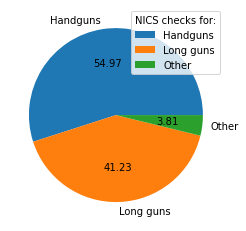

In [43]:
plt.pie(proportion, labels=mylabels, autopct='%.2f');
plt.legend(title='NICS checks for:');

I knew that "other" constituted a very small portion of the data, but I was concerned that handguns may constitute a high enough proportion of the data to have significantly different trends which would be concealed by comparison with a "total" measure. With a 55/45 split between handguns and non-handguns, that appears unlikely to occur, and some preliminary exploration of relationships with these prior to writing this report indicated that to be the case. 

<a id='question1'></a>
### Q1: How do population and population change impact firearms transactions?
In order to examine this question, we must compare percentage changes in firearms transactions by state with percentage changes in population by state.  First, taking a look at the nature of some of the data in `df_diff`: 

In [44]:
df_diff.head()

,total_2010,total_2016,guns_pct_diff,pop_2010,pop_2016,pop_pct_diff
state,,,,,,
Alabama,25717,51412,99.914453,4780131,4863300,1.7
Alaska,5492,7303,32.975237,710249,741894,4.5
Arizona,17170,34264,99.557368,6392301,6931071,8.4
Arkansas,15954,21581,35.270152,2916025,2988248,2.5
California,68033,198097,191.177811,37254522,39250017,5.4


In [45]:
print("The mean percent difference from 2010 - 2016 in NICS transactions is: ", df_diff['guns_pct_diff'].mean())
print("The standard deviation for this value is: ", df_diff['guns_pct_diff'].std())
print("The minimum for this value is: ", df_diff['guns_pct_diff'].min())
print("The maximum for this value is: ", df_diff['guns_pct_diff'].max())
print("\nThe mean percent difference from 2010 - 2016 in population is: ", df_diff['pop_pct_diff'].mean())
print("The standard deviation for this value is: ", df_diff['pop_pct_diff'].std())
print("The minimum for this value is: ", df_diff['pop_pct_diff'].min())
print("The maximum for this value is: ", df_diff['pop_pct_diff'].max())

The mean percent difference from 2010 - 2016 in NICS transactions is:  84.8817818328138
The standard deviation for this value is:  55.03268213588737
The minimum for this value is:  -46.7327634833167
The maximum for this value is:  315.6610193028746

The mean percent difference from 2010 - 2016 in population is:  4.180000000000002
The standard deviation for this value is:  3.3810999297113176
The minimum for this value is:  -1.2
The maximum for this value is:  12.7


It is immediately apparent that NICS checks have increased at a far greater rate (mean: 84.9%) than the population has increased (mean: 4.2%) in the same timeframe. The disparity of this data could indicate that there is not much of a relationship between the change in population and the change in NICS transactions, which we can verify with a scatterplot and checking the correlation of the two.  

The correlation of guns_pct_diff to pop_pct_diff is:  -0.09259


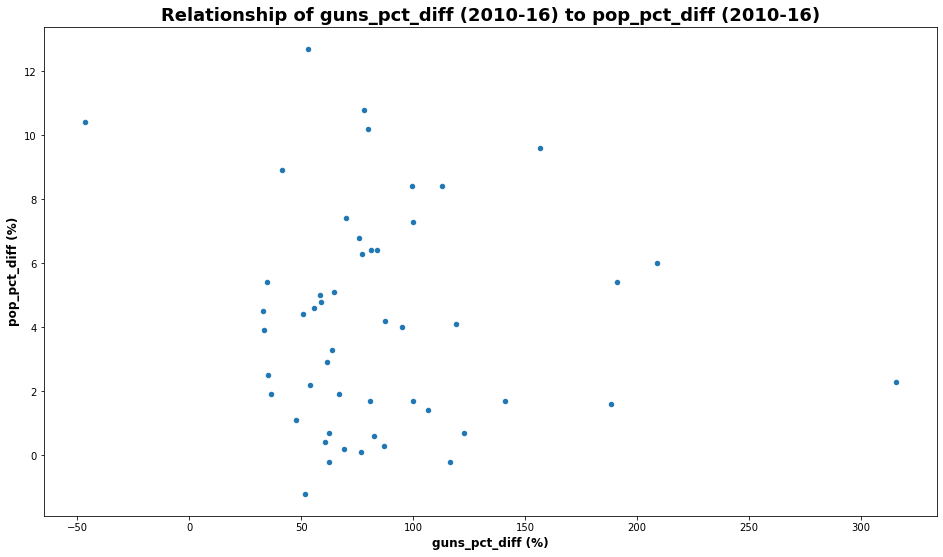

In [46]:
df_diff.plot(x='guns_pct_diff', y='pop_pct_diff', kind='scatter', figsize = (16, 9));
plt.title('Relationship of guns_pct_diff (2010-16) to pop_pct_diff (2010-16)', fontsize = 18, weight = 'bold')
plt.xlabel('guns_pct_diff (%)', fontsize = 12, weight = 'bold')
plt.ylabel('pop_pct_diff (%)', fontsize = 12, weight = 'bold')
print('The correlation of guns_pct_diff to pop_pct_diff is: ', round(df_diff['guns_pct_diff'].corr(df_diff['pop_pct_diff']), 5))

This scatterplot does not imply any significant relationship between these two means, which the correlation of -0.093 supports. This is somewhat surprising, as we would intuitively expect that population (and thus, population changes) would have a strong relationship with the use of a service and the purchase of merchandise. Of particular note here is the high standard deviations relative to the mean for both sets of data, showing that our data is highly variable. Examining the raw data from the FBI NICS database shows that the database has changed and grown significantly in both the collected values and its usage by states over the course of its existence (dating back to the 1990s), and that a significant amount of change has happened over these 6 years. Even if there were a significant relationship between the population change and the NICS change, it would likely be confounded to some degree by this change.  

A comparison of the 5 states with the smallest percentage changes in the NICS database would be most likely to mitigate noise caused by states who've made significant changes to how they use the NICS database.  

In [47]:
top_5 = df_diff.sort_values(by='guns_pct_diff').head(6) # Sorting by ascending change in usage, limited to smallest 6 results
top_5

,total_2010,total_2016,guns_pct_diff,pop_2010,pop_2016,pop_pct_diff
state,,,,,,
Utah,46094,24553,-46.732763,2763888,3051217,10.4
Alaska,5492,7303,32.975237,710249,741894,4.5
Wyoming,3975,5295,33.207547,563767,585501,3.9
Montana,8424,11361,34.864672,989414,1042520,5.4
Arkansas,15954,21581,35.270152,2916025,2988248,2.5
Kansas,12013,16377,36.327312,2853129,2907289,1.9


These are the 6 states with the smallest changes in NICS usage. Even being the 6 smallest in this regard, each one has a delta of over 30%.  I was hoping to find values closer to 0 which could indicate a relative same-ness in how the NICS system was used in that state, but this does not appear to be the case with any state.  We can also see here that Utah is the only state whose NICS transactions went down from 2010 to 2016, and Utah also had one of the highest population increases in this timeframe as well.  As a result, we'll eliminate Utah as an outlier in the other direction and check those states ranked 2 - 6. 

In [48]:
top_5.drop(index='Utah', inplace=True)

Among the 5 states with the smallest percent change in NICS checks, the correlation of guns_pct_diff to pop_pct_diff is:  -0.62171


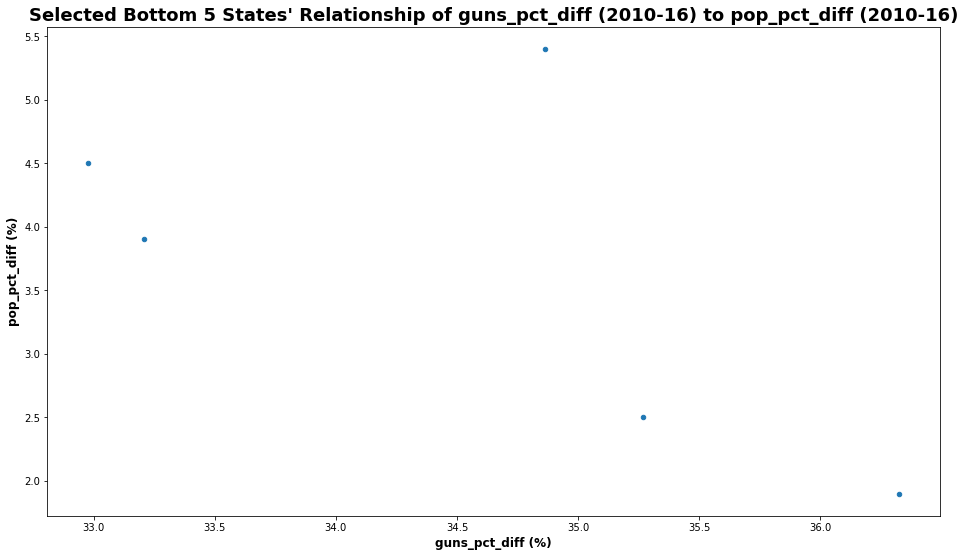

In [49]:
top_5.plot(x='guns_pct_diff', y='pop_pct_diff', kind='scatter', figsize = (16, 9));
plt.title("Selected Bottom 5 States' Relationship of guns_pct_diff (2010-16) to pop_pct_diff (2010-16)", fontsize = 18, weight = 'bold')
plt.xlabel('guns_pct_diff (%)', fontsize = 12, weight = 'bold')
plt.ylabel('pop_pct_diff (%)', fontsize = 12, weight = 'bold')
print('Among the 5 states with the smallest percent change in NICS checks, the correlation of guns_pct_diff to pop_pct_diff is: ', round(top_5['guns_pct_diff'].corr(top_5['pop_pct_diff']), 5))

Here, we start to see a moderate negative linear relationship between increasing population of a state and the number of firearms transactions in that state (correlation: -0.62). However, the small sample size here makes this data less representative of the nationwide set.  We can test to see how well this relationship may hold by expanding the sample size from the bottom 5 states to the bottom 10, again ignoring Utah.  

In [50]:
top_10 = df_diff.sort_values(by='guns_pct_diff').head(11)
top_10.drop(index='Utah', inplace=True)

Among the 10 states with the smallest percent change in NICS checks, the correlation of guns_pct_diff to pop_pct_diff is:  0.1235


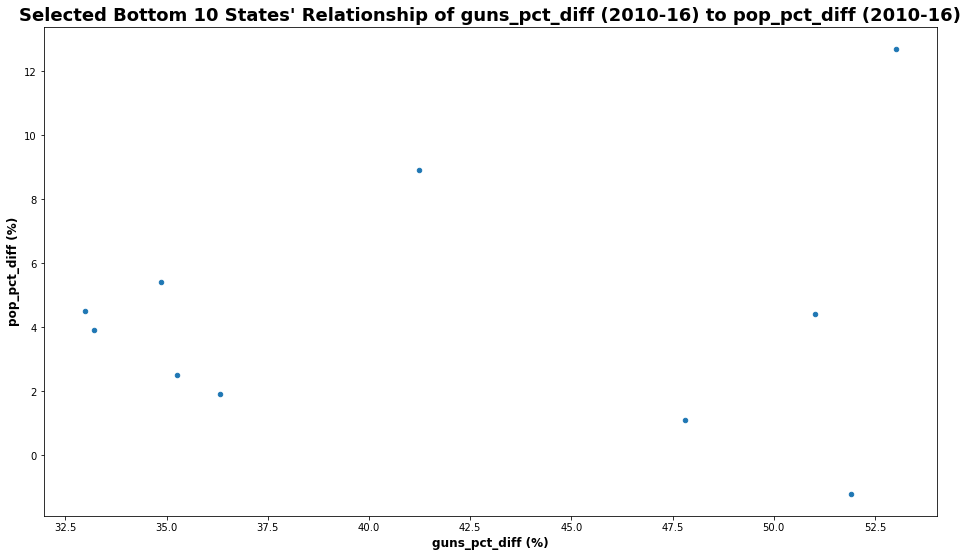

In [51]:
top_10.plot(x='guns_pct_diff', y='pop_pct_diff', kind='scatter', figsize = (16, 9));
plt.title("Selected Bottom 10 States' Relationship of guns_pct_diff (2010-16) to pop_pct_diff (2010-16)", fontsize = 18, weight = 'bold')
plt.xlabel('guns_pct_diff (%)', fontsize = 12, weight = 'bold')
plt.ylabel('pop_pct_diff (%)', fontsize = 12, weight = 'bold')
print('Among the 10 states with the smallest percent change in NICS checks, the correlation of guns_pct_diff to pop_pct_diff is: ', round(top_10['guns_pct_diff'].corr(top_10['pop_pct_diff']), 5))

Expanding the sample size quickly led to the relationship between population change and firearms transactions largely disappearing (-0.62 to 0.12).  This could indicate that the 5 states with the smallest changes in their use of the NICS system are actually outliers themselves.  Another way to try to eliminate the noise caused by outliers would be to take the middle 40 states, subtracting the 5 at each end of the dataset as outliers.  

In [52]:
mid_40 = df_diff.sort_values(by='guns_pct_diff').iloc[5:45] # Taking rows 5 - 45 (exclude top and bottom 5)

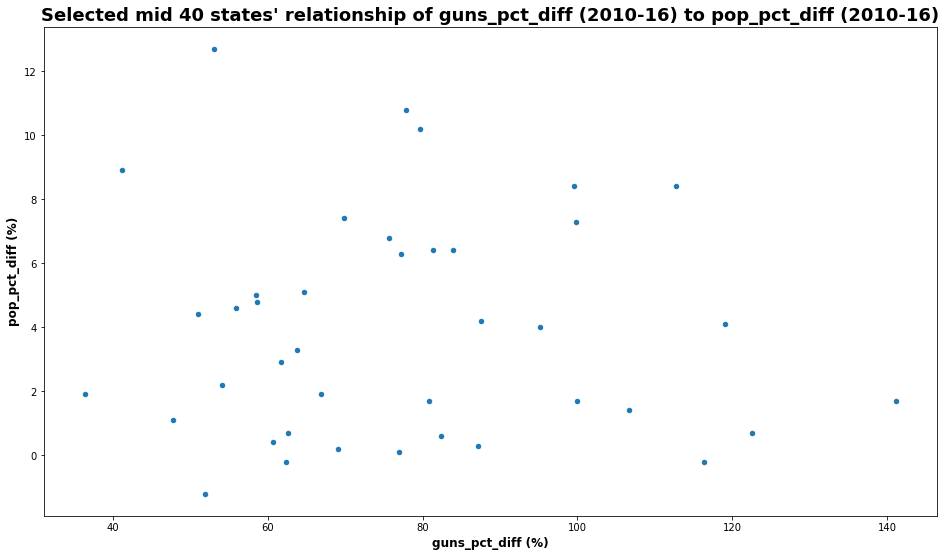

In [53]:
mid_40.plot(x='guns_pct_diff', y='pop_pct_diff', kind='scatter', figsize = (16, 9))
plt.title("Selected mid 40 states' relationship of guns_pct_diff (2010-16) to pop_pct_diff (2010-16)", fontsize = 18, weight = 'bold')
plt.xlabel('guns_pct_diff (%)', fontsize = 12, weight = 'bold')
plt.ylabel('pop_pct_diff (%)', fontsize = 12, weight = 'bold');

In [54]:
print("The correlation for the middle 40 states in percent change in NICS transactions is: ", round(mid_40['guns_pct_diff'].corr(mid_40['pop_pct_diff']), 5))
print("\nFor the middle 40 states in percent change in NICS transactions...")
print("The mean percent difference from 2010 - 2016 in NICS transactions is: ", mid_40['guns_pct_diff'].mean())
print("The standard deviation for this value is: ", mid_40['guns_pct_diff'].std())
print("The minimum for this value is: ", mid_40['guns_pct_diff'].min())
print("The maximum for this value is: ", mid_40['guns_pct_diff'].max())
print("\nThe mean percent difference from 2010 - 2016 in population is: ", mid_40['pop_pct_diff'].mean())
print("The standard deviation for this value is: ", mid_40['pop_pct_diff'].std())
print("The minimum for this value is: ", mid_40['pop_pct_diff'].min())
print("The maximum for this value is: ", mid_40['pop_pct_diff'].max())

The correlation for the middle 40 states in percent change in NICS transactions is:  -0.04988

For the middle 40 states in percent change in NICS transactions...
The mean percent difference from 2010 - 2016 in NICS transactions is:  77.34305661596855
The standard deviation for this value is:  24.110260395590373
The minimum for this value is:  36.327312078581535
The maximum for this value is:  141.187648456057

The mean percent difference from 2010 - 2016 in population is:  3.9349999999999996
The standard deviation for this value is:  3.472274803020681
The minimum for this value is:  -1.2
The maximum for this value is:  12.7


These statistics indicate that I significantly refined my dataset by removing the top and bottom 10% of states' changes to usage of the NICS system.  This is evident in the range between maximum and minimum, compared to the entire dataset at the start of this exploration.  This is also demonstrated by a large reduction in the standard deviation relative to the mean, though the standard deviation of this dataset is still quite large.  Even with these refinements though, there still doesn't appear to be a significant relationship between the two, even though it intuitively feels like there should be a relationship between population growth and NICS usage growth.  

That assumption based upon my intuition has been disproven, and it begs the question of if there is even a relationship between population and total NICS transactions.  If there is, it may indicate confounding factors at play here.  If there is not, it indicates that my intuition was entirely wrong. We can compare the raw population data for 2010 and 2016 against the associated NICS data to check this. 

The correlation for the relationship between 'total_2010' and 'pop_2010' is:  0.4283


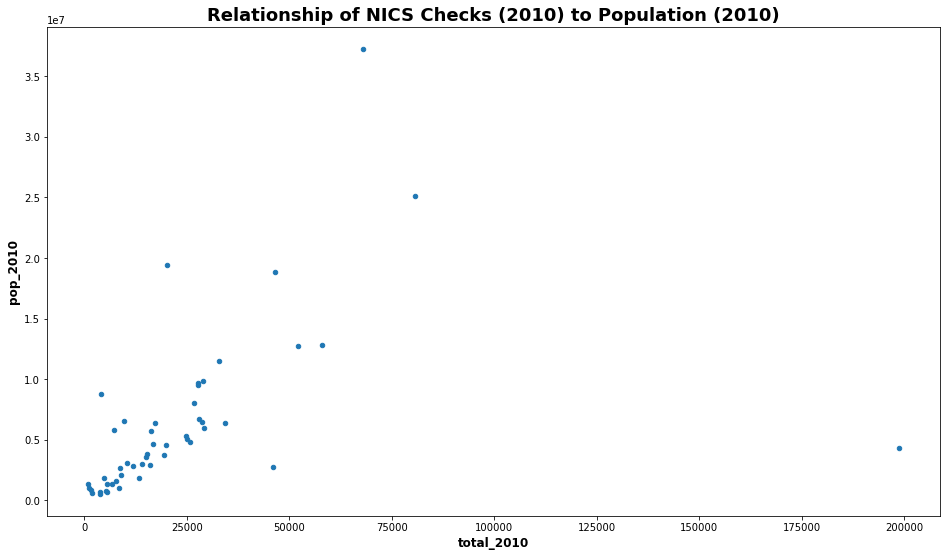

In [55]:
df_diff.plot(x='total_2010', y='pop_2010', kind='scatter', figsize = (16, 9));
plt.title("Relationship of NICS Checks (2010) to Population (2010)", fontsize = 18, weight = 'bold')
plt.xlabel('total_2010', fontsize = 12, weight = 'bold')
plt.ylabel('pop_2010', fontsize = 12, weight = 'bold')
print("The correlation for the relationship between 'total_2010' and 'pop_2010' is: ", round(df_diff['total_2010'].corr(df_diff['pop_2010']), 5))

The correlation for the relationship between 'total_2016' and 'pop_2016' is:  0.60712


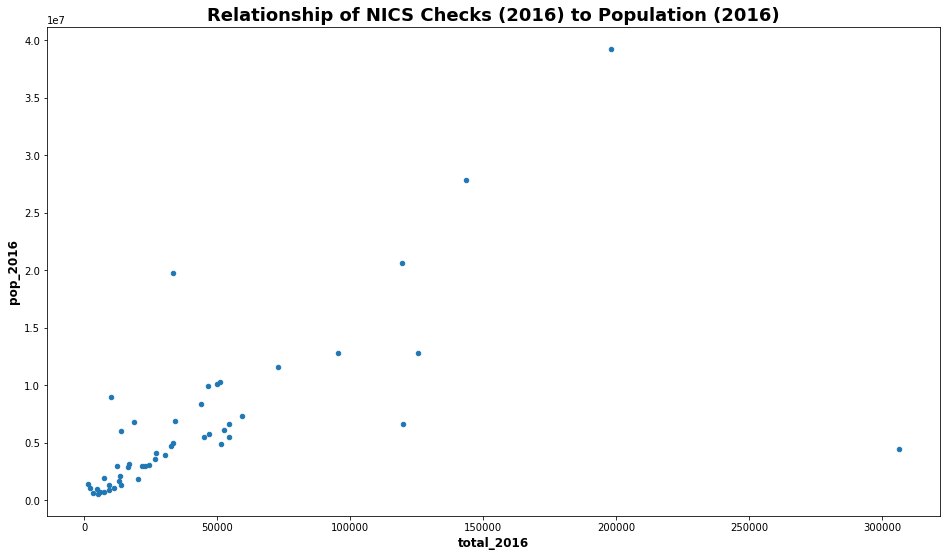

In [56]:
df_diff.plot(x='total_2016', y='pop_2016', kind='scatter', figsize = (16, 9));
plt.title("Relationship of NICS Checks (2016) to Population (2016)", fontsize = 18, weight = 'bold')
plt.xlabel('total_2016', fontsize = 12, weight = 'bold')
plt.ylabel('pop_2016', fontsize = 12, weight = 'bold')
print("The correlation for the relationship between 'total_2016' and 'pop_2016' is: ", round(df_diff['total_2016'].corr(df_diff['pop_2016']), 5))

For both the 2010 and 2016 data, there is clearly a positive linear relationship between population and NICS checks, though not a particularly strong one. This is very apparent on both charts, though both of them have a very obvious outlier off of that trendline, in the bottom right.  Out of curiosity, I checked what state this outlier was, and I found that in both charts, it was Kentucky.  This led to some additional exploration of the published FBI reports and some findings about how the use of the NICS system has changed over time, and when.  

<a id='aside'></a>
### An Aside: Kentucky, Illinois, and NICS Permit Data

Outside of the dataset provided by Udacity, examining the more recent reports on this data published by the FBI really underlines just how much of an outlier Kentucky really is in regards to any examination of the NICS data, at any point in time throughout the system's existence.  Kentucky is one of the reasons why the permit recheck data was omitted from this report, being one of 3-5 states in recent years doing hundreds of thousands of permit rechecks per month, where the vast majority of states are doing only a few thousand.  In more recent data, these rechecks from a handful of states actually constitute the largest category of NICS checks performed and over a third of all NICS checks performed nationally.  

Looking at the raw 2016 month-to-month data, the total monthly NICS checks were in the area of about 1.8 - 2.2 million, with "permits" alone comprising about one third of that total. Kentucky is generally running 230 - 330 thousand permit checks per month during 2016, around 25-40% of the total permits and 10-20% of **ALL** checks done nationally for any reason. In the more recent published FBI data, Kentucky is doing more normal numbers of (new) permits (<5,000 per month), and their permit rechecks far exceed every other state (hundreds of thousands per month). During the 2010 and 2016 periods, Kentucky is very noticeably doing hundreds of thousands of checks each month, but 0 of those are permit rechecks.  This made me suspicious that Kentucky's numbers are actually overwhelmingly permit rechecks not tabulated as such, which I had chosen to exclude from this analysis. Strangely, in Aug 2016, Kentucky's permits dropped from hundreds of thousands to under 10,000, just for that month, before going back up to 300,000+ in Sep 2016.

In accounting for how big an impact Kentucky had on the national data, it was quickly obvious that the only other state doing hudnreds of thousands of permits monthly was Illinois, running anywhere from 1/3 to 1/2 of the number of permits as Kentucky. In Aug 2016, Illinois suddenly went from doing ~100,000 permits per month to just 20,000, placing them in the high-middle range of this dataset. At the same time, their permit rechecks went from 0 to ~80,000. Aug 2016 was the same month that Kentucky's permits also cratered inexplicably, before going right back up. This would lend further credence to the idea that some sort of change happened in Aug 2016 with regard to how states were using the NICS checks, or how their usage was categorized or reported.  Kentucky's permit counts would remain in the 300,000 range until mid-2019, when almost that entire number became categorized as permit rechecks and only a few thousand as "new" permits. 

These two states drove nearly 50% of the permit data for 2010, and would've done so again in 2016 had Illinois not started reporting "rechecks" in Aug 2016. In 2016, the two accounted for about 40% of the total. It's unknown if other states were also lumping in permit rechecks with new permits, as it seems clear Illinois was (and I suspect Kentucky was as well).  This means that any examination of permit data will have to involve dumping Illinois and Kentucky's results. This also means that on the 2016 data for the next part of this analysis, the permits column will have to be drumped and totals will be recalculated across handguns, long guns, and others. I'll also take one more look at the population change data explored in the first question in this study. While I could justify starting over and removing the permit data entirely, Illinois and Kentucky were fairly consistent in the proportion of total permits they were generating compared to the other 48 states over this timeframe. With each state being grouped only by its own data and the only overtly suspicious data removed, I don't find that necessary in this case. 

<a id='question1part2'></a>
### Q1: Population Change Part 2

Picking back up with the original question before a deep dive on outliers and problems in the data, we found a positive linear relationship between population and NICS checks, which wasn't a big surprise, but this made it more unusual that no relationship was visible between percentage changes in population and NICS checks. This is especially strange because the correlation between population and NICS checks increased over the time period in question, from 0.43 in 2010 to 0.61 in 2016. This likely speaks to the amount of noise present in the NICS data, especially in terms of structural changes between 2010 and 2016, such as how the system is used, how uses are classified & reported, etc. Having found out just how strongly the data is being influenced by Kentucky and, to a lesser extent, Illinois, it seems prudent to try one more check of the "mid 40" data, excluding Kentucky and Illinois there.  

In [57]:
mid_40.drop(index='Kentucky', inplace=True)
mid_40.drop(index='Illinois', inplace=True)

The correlation for the relationship between 'total_2016' and 'pop_2016' is:  -0.01286


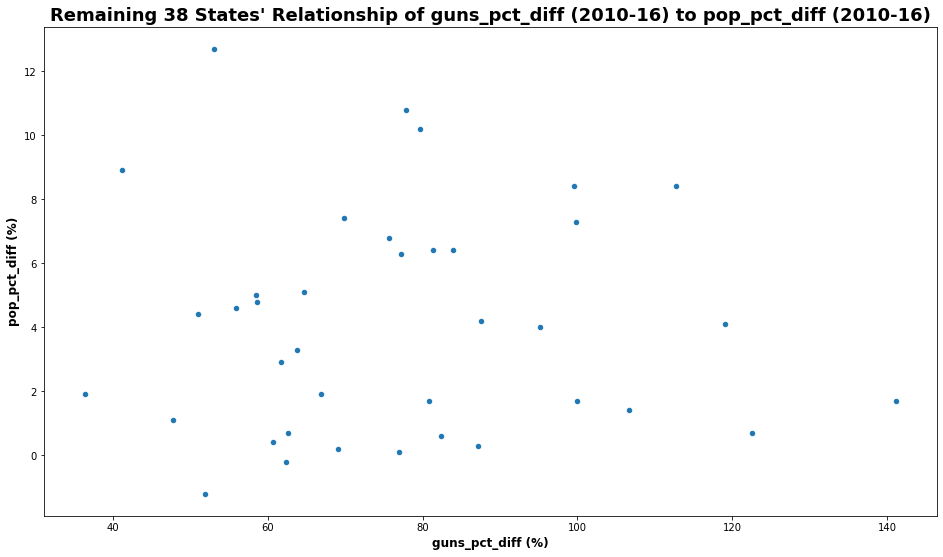

In [58]:
mid_40.plot(x='guns_pct_diff', y='pop_pct_diff', kind='scatter', figsize = (16, 9))
plt.title("Remaining 38 States' Relationship of guns_pct_diff (2010-16) to pop_pct_diff (2010-16)", fontsize = 18, weight = 'bold')
plt.xlabel('guns_pct_diff (%)', fontsize = 12, weight = 'bold')
plt.ylabel('pop_pct_diff (%)', fontsize = 12, weight = 'bold')
print("The correlation for the relationship between 'total_2016' and 'pop_2016' is: ", round(mid_40['guns_pct_diff'].corr(mid_40['pop_pct_diff']), 5))

The previous "mid 40" check had a correlation of -0.05, and having removed Kentucky and Illinois as extreme outliers, the correlation went down to -0.01. At this point, I've established a moderately strong relationship between population and NICS checks, but no discernible relationship between population change and changes in NICS transactions for the time period between 2010 and 2016.

### Q2: How do other societal metrics impact firearms transactions?  

This research project was formulated on the idea that there would be a relationship between population change and firearms transactions. Once that was established, other societal metrics indicative of a state's average income, education, affluence, etc. could then be examined to see if these had a stronger or weaker relationship with firearms transactions, or if population change was really "driving the bus" in this regard. While I was surprised by my results in the first portion of this analysis, it only makes me more interested to find if *any* of the metrics that I thought would meaningfully correlate with firearms transactions actually do so.  

Before beginning my exploratory analysis here, I do have to fix up my data to eliminate permits. This means that my NICS data will more accurately reflect actual transactions involving a firearm. 

In [59]:
# Drop columns for permits and total (which included permits)
df_clean.drop(['total', 'new_permits'], axis=1, inplace=True)
# Recalculate the total from just handguns, long guns, and other
df_clean.insert(loc=3, column='total_guns', value=df_clean['all_handguns'] + df_clean['all_long_guns'] + df_clean['all_others'])

In [60]:
df_clean.head(1)

,all_handguns,all_long_guns,all_others,total_guns,pop_2016,veterans,median_value_housing,median_rent,building_permits,hs_graduates_25+,bach_graduates_25+,median_household_income,poverty_rate,pop_per_sq_mile
state,,,,,,,,,,,,,,
Alabama,14445.416667,11653.416667,514.333333,26613.166667,4863300,363170,125500,717,15001,84.3,23.5,43623,17.1,94


Given that the remainder of this study will involve only comparing various 2016 social data against the `total_guns` variable indicating 2016 firearms transactions to determine their relationships, a quick function can be written to simplify this work. This function will output scatter plots for two columns in this dataframe, calculate and print the correlation, and store that correlation for later comparison.

In [61]:
corr_dict = {}

In [62]:
def scatter_n_save_corr(dataframe, column_x, column_y):
    ''' Prints a scatter plot of the relationship between dataframe[column_x] and 
    dataframe[column_y], complete with title, xlabel, and ylabel. Also prints the
    correlation between the two, and saves the value to a previously established
    'corr_dict' dictionary to be accessed later. The dependent variable (the one 
    being measured for impact by other variables) must always be column_x.
    '''
    dataframe.plot(x = column_x, y = column_y, kind = 'scatter', figsize = (16, 9));
    plt.title(f'Relationship of {column_x} to {column_y} in 2016', fontsize = 18, weight = 'bold')
    plt.xlabel(column_x, fontsize = 12, weight = 'bold')
    plt.ylabel(column_y, fontsize = 12, weight = 'bold')
    new_corr = round(dataframe[column_x].corr(dataframe[column_y]), 5) # Calculate correlation of x & y, rounded to 5 decimal places
    print(f'The correlation between {column_x} and {column_y} is: {new_corr}') # Formatted string returns correlation
    corr_dict.setdefault(column_y, new_corr) # Adds independent variable (key) and correlation (value) to 'corr_dict'

Previously, I had compared population change rate against NICS checks change rate, and found no meaningful relationship. I also compared population in 2010 against NICS checks in 2010, and did the same with 2016 data, though both of these datapoints included permits, which we've since discovered was problematic due to a number of reasons, including inconsistencies in how the NICS data was used and tabulated. As I've now put together a dataframe that excludes those permits in 'total_guns', I'll check again how 'pop_2016' compares to the measure of total firearms transactions, without having potentially messy permits data in the comparison.

The correlation between total_guns and pop_2016 is: 0.88335


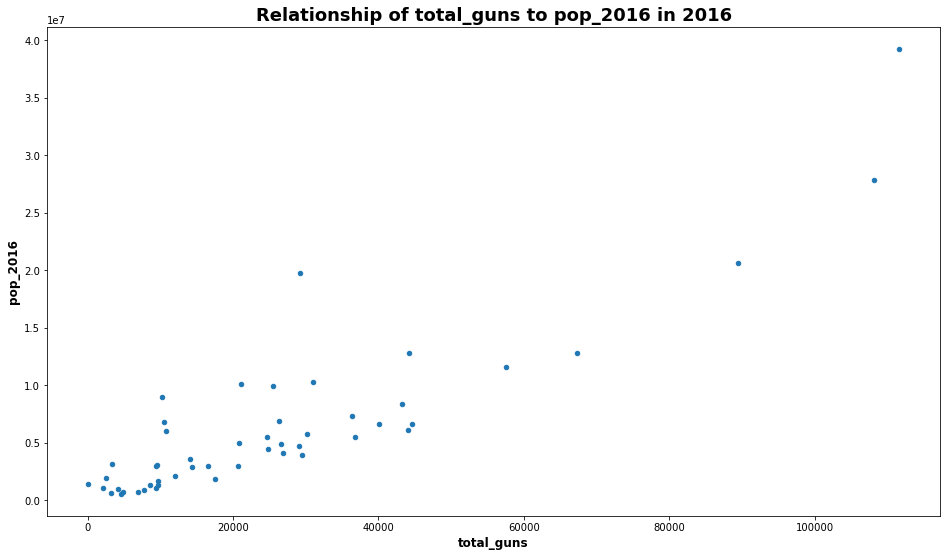

In [63]:
scatter_n_save_corr(df_clean, 'total_guns', 'pop_2016')

This graph shows a very apparent strong positive linear relationship between population and firearms transactions, with a correlation of 0.88. The correlation for pop_2016 against the data including permits was only 0.61. 

Using NICS checks as a representative for transactions involving firearms, I wanted to start by checking if this was higher in more rural states. I personally think about shooting and hunting being more popular hobbies in rural areas, where more opportunities exist to use a gun outdoors. 

The correlation between total_guns and pop_per_sq_mile is: -0.03065


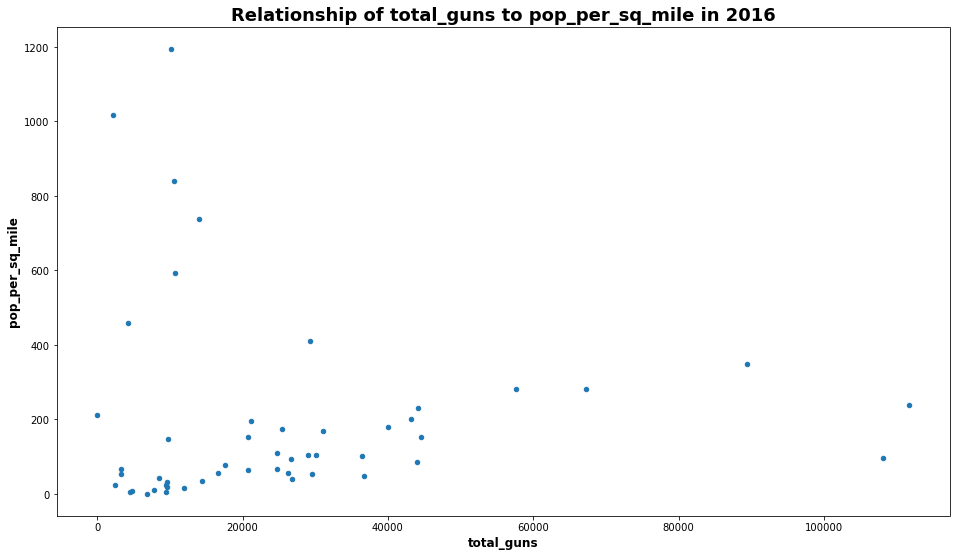

In [64]:
scatter_n_save_corr(df_clean, 'total_guns', 'pop_per_sq_mile')

There's no real relationship here between population per square mile and firearms transactions. While there is a cluster in the bottom left, the datapoints quickly spread widely to the top left and bottom right, rather than following any clear pattern, linear or otherwise.  

Next, I'll check for any link between education (age 25+ high school graduates and age 25+ 4-year college graduates) and firearms transactions.  

The correlation between total_guns and hs_graduates_25+ is: -0.47329


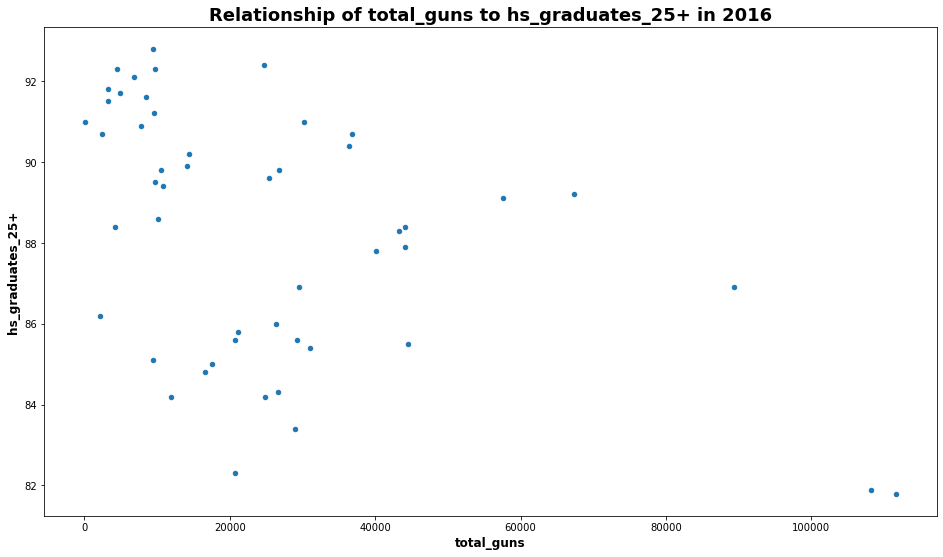

In [65]:
scatter_n_save_corr(df_clean, 'total_guns', 'hs_graduates_25+')

The correlation between total_guns and bach_graduates_25+ is: -0.06561


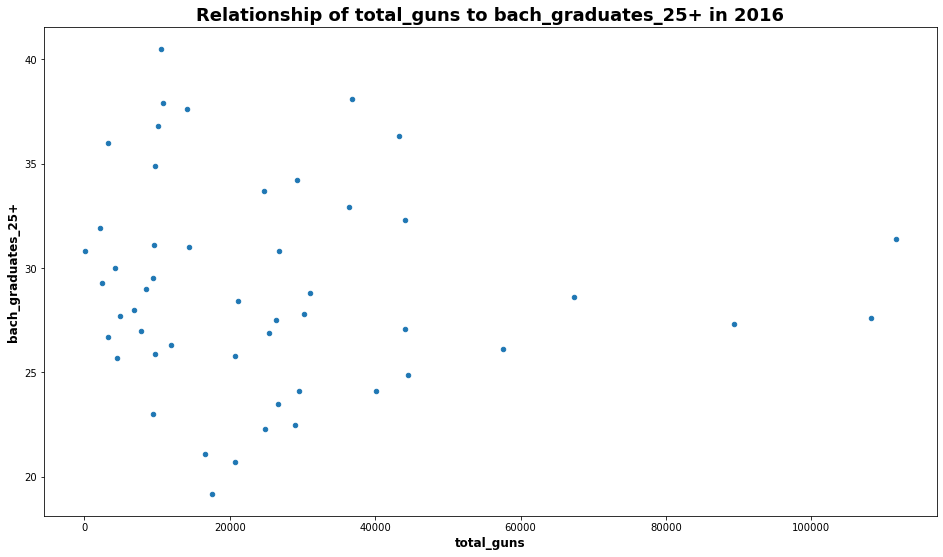

In [66]:
scatter_n_save_corr(df_clean, 'total_guns', 'bach_graduates_25+')

The more compact nature of the hs_graduates_25+ graph indicates a negative linear relationship between high school graduation rate and number of firearms transactions, though its not particularly strong. As high school graduation rate increases in each state, firearms transactions in that state go down, as indicated by the correlation of -0.47.

Interestingly, this relationship disappears amongst college graduates. If increased education were related to reduced gun transactions or popularity, we'd expect to see the correlation increase with higher education levels, or at least remain similar. That this relationship disappears entirely may indicate that it is not actually a higher level of education driving the relationship seen here for high school graduated, but instead another factor which also results in higher high school graduation. More analysis would be needed to confirm this (such as checking against highest grade completed, rather than these two thresholds), but these two datapoints would seem to indicate that this is very possible.

Moving on to the number of veterans in each state:

The correlation between total_guns and veterans is: 0.93377


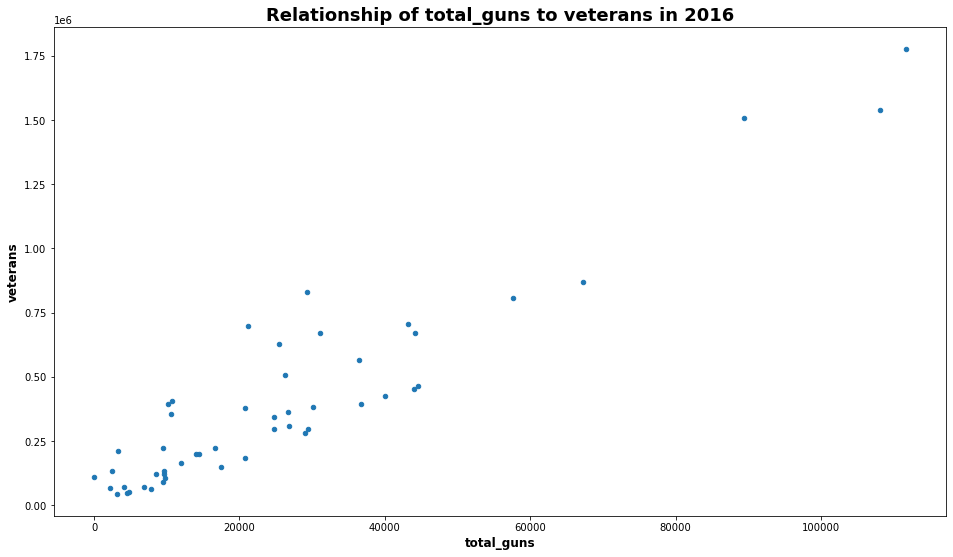

In [67]:
scatter_n_save_corr(df_clean, 'total_guns', 'veterans')

A correlation of 0.93 indicates a strong positive relationship between these two values, which the graph definitely confirms. This is easily the strongest relationship seen in this study, even stronger than the one seen between population and firearms transactions. That makes a lot of sense because veterans are a subset of the population which have self-selected into a group who are willing to handle and be extensively trained with a variety of firearms. 

Next, we'll look at the relationship between income and firearms transactions.

The correlation between total_guns and median_household_income is: -0.13779


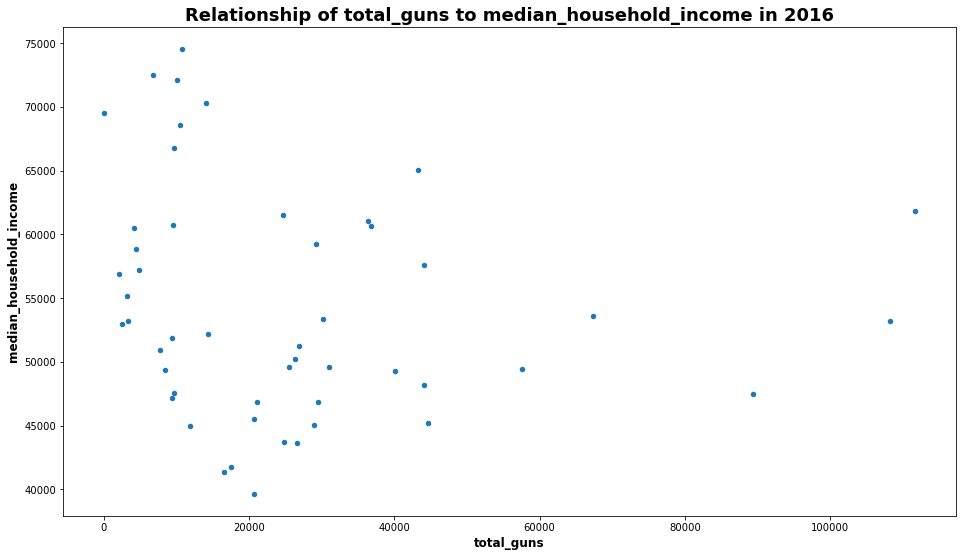

In [68]:
scatter_n_save_corr(df_clean, 'total_guns', 'median_household_income')

A very weak negative relationship exists here (as median household income increases, firearms transactions decrease), but not strong enough to be particularly meaningful. 

Household income being more indicative of individual affluence and economic well-being, I also want to examine several other measures of state-wide affluence (or lack thereof), starting with median housing value and median rent value.

The correlation between total_guns and median_value_housing is: -0.05123


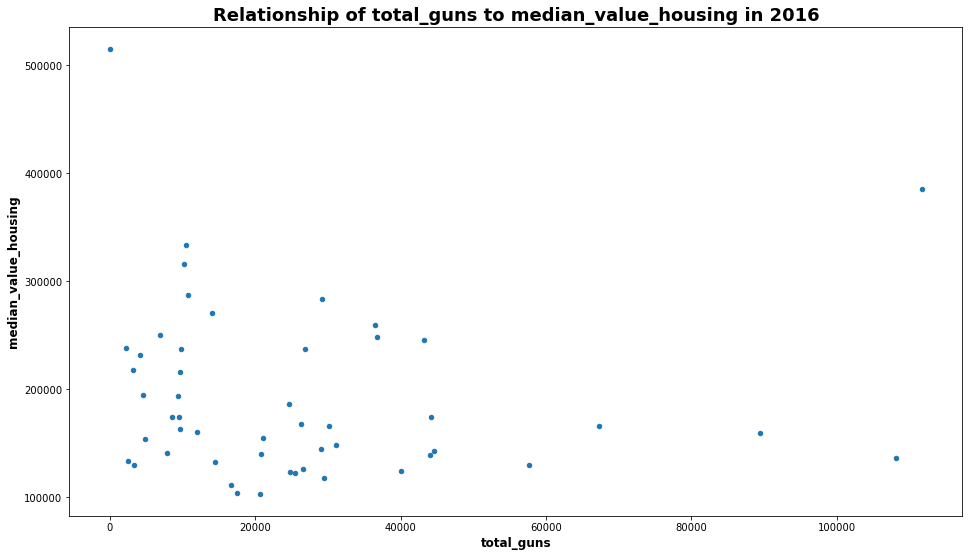

In [69]:
scatter_n_save_corr(df_clean, 'total_guns', 'median_value_housing')

The correlation between total_guns and median_rent is: 0.10558


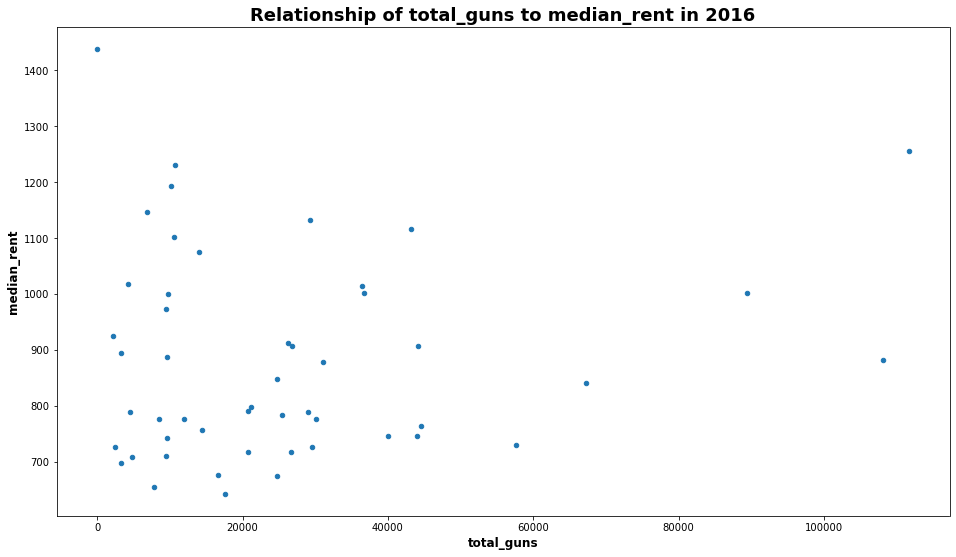

In [70]:
scatter_n_save_corr(df_clean, 'total_guns', 'median_rent')

Again, for both metrics there is no meaningful relationship with firearms transactions. These graphs look very similar, which makes sense because both represent a state's cost of living. Arguably, I could've used only a single metric as a result, but I wanted to include both in case there was a wealth inequality component potentially coming into play. It appears that was not the case. For state-wide affluence indicators, I also chose to use poverty rate, which directly speaks to a lack of economic success, and building permits, which indicates a state's stagnation or productive growth.

The correlation between total_guns and building_permits is: 0.83767


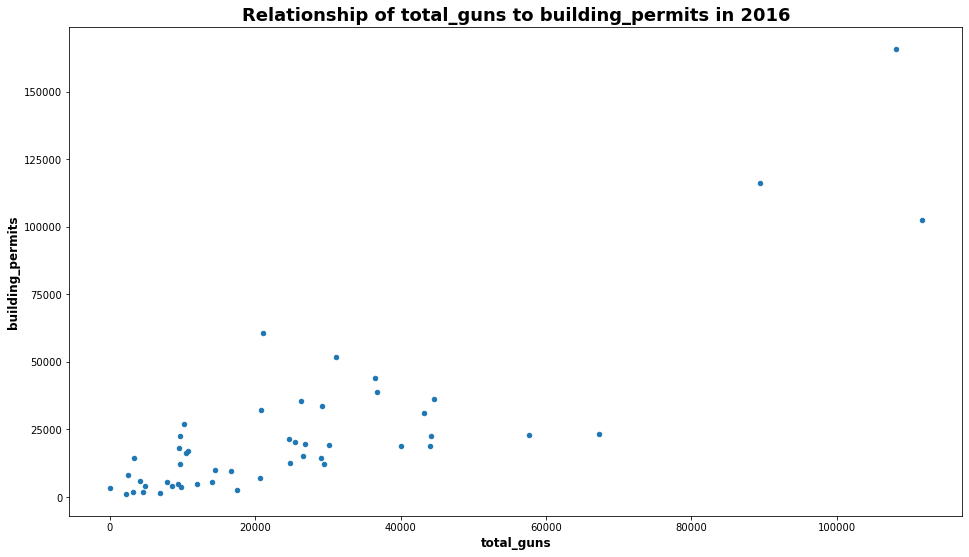

In [71]:
scatter_n_save_corr(df_clean, 'total_guns', 'building_permits')

The correlation between total_guns and poverty_rate is: 0.25624


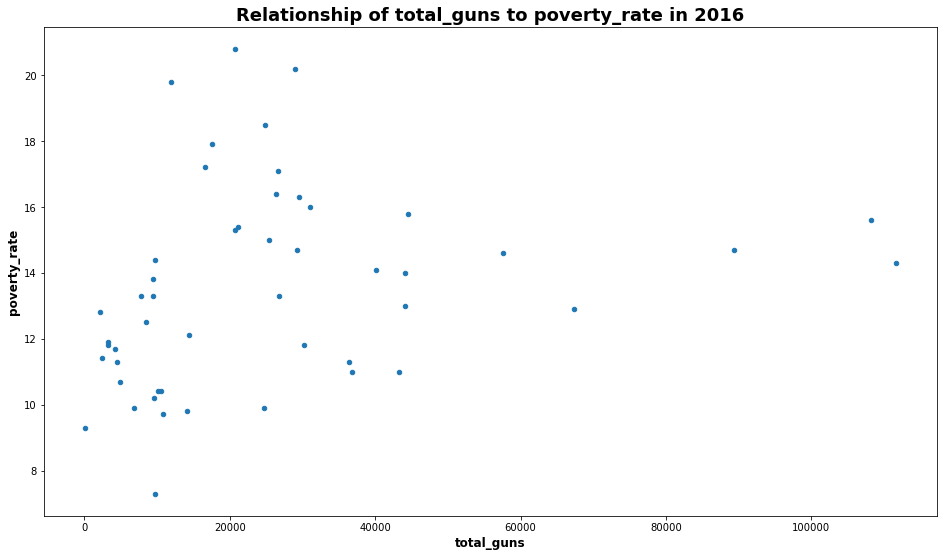

In [72]:
scatter_n_save_corr(df_clean, 'total_guns', 'poverty_rate')

This is a pretty interesting result.  A weak linear relationship exists between poverty rate and firearms transactions, but we see a fairly strong positive linear relationship between building permits and firearms transactions. With all four of these last state-wide indicators of a state's economic success, I expected all four to chart in relatively similar fashions, and as a result I gave consideration to removing some of them in anticipating their redundancy. I'm surprised that this was very much not the case.

Having saved all of the correlations for different societal measures against 'total_guns', the stored values can be placed into a Series for easy graphing.

In [73]:
correlations_2016 = pd.Series(corr_dict)

<a id='conclusions'></a>
## Conclusions

This project was selected from a handful of options as an opportunity to look into how a variety of census metrics interact with NICS checks as a representative measure for firearms transactions. This was intended to start with taking measure of how those firearms transactions relate to population as a starting point, and then other societal variables could be compared to determine if they had a stronger or weaker link than did population. This seemed like an especially relevant topic to investigate based on current events, as firearms purchases have risen enormously in the United States during the COVID-19 pandemic and the 2020 U.S. Presidential election. 

I was surprised that the relationships between population and firearms transactions in 2010 and 2016 were not stronger (growing from 0.43 to 0.61). Having checked those findings against a more accurate representation of firearms transactions (when permits were excluded later in the exploratory data analysis, I found a much stronger positive relationship that made more sense (correlation of 0.88). This is evidence that there is a strong link between increased population and increased firearms sales, though the complete absence of a relationship between rate of change in population and in NICS checks remains odd. This also indicates just how problematic the NICS data is, especially with regard to their tabulation of checks done for permits. 

There was significant consideration given to starting the study over and excluding the permits results, and a future analysis would certainly do so from the beginning. However, I do believe it is useful to demonstrate how problematic this particular portion of the FBI's NICS data is. While my examination of more recent published reports indicate that some of this issue may have been addressed by the FBI, as indicated by rechecks having gone up dramatically since 2016, especially by the most obvious outliers described in this report, those are very recent changes which have not been consistently made. For example, Kentucky's changes were not made until summer 2019 over several months, while Illinois' were made in Aug 2016 all at once, and Indiana (another outlier whose share of the whole grew after Illinois' tabulation was corrected) did not make changes until doing so over several months in early 2019. These issues mean that very little of value can be taken from the permits and permit recheck data, and it calls into question the accuracy of the FBI's entire dataset. I believe that this finding has significant social value, and that is why I decided to keep the study in its current form.  

As mentioned, the indications of a strong relationship between firearms transactions and raw population cast more doubt onto the absence of a relationship seen with rate of population change. That a relationship doesn't exist implies either significant confounding factors or limitations of my analysis could be at issue. Potential concerns here include:
- The observed relationship between population and firearms transactions isn't driven by population but by another factor which also impacts or approximates population. 
- Other changes or inconsistencies in the FBI's NICS data may exist beyond those already described in this report.
- Firearms transactions may not be driven by population but by another factor coinciding with population, such as a state's pro-gun culture and more populous states having more people to indulge in that culture. This could drive an effect which looks like population but is more about entrenchment of pro-gun cultures.

In considering that final possibility, it is impossible to divorce this data and its timing in 2016 from the political situation going into the 2016 U.S. elections, with increased radicalization and tribalism from the political extremes. This is a topic far, far outside the scope of this paper, but at a unique time in United States history, this could've led to changes in purchasing habits for Americans in different states, especially states with entrenched or extreme political leanings. This would be a really fun and interesting topic to explore, and I can think of some ways to do so, but all of that is outside the scope of this report.

Regarding the various social metrics which were examined, relationships for each with the average monthly firearms transactions in 2016 were quantified and compiled.

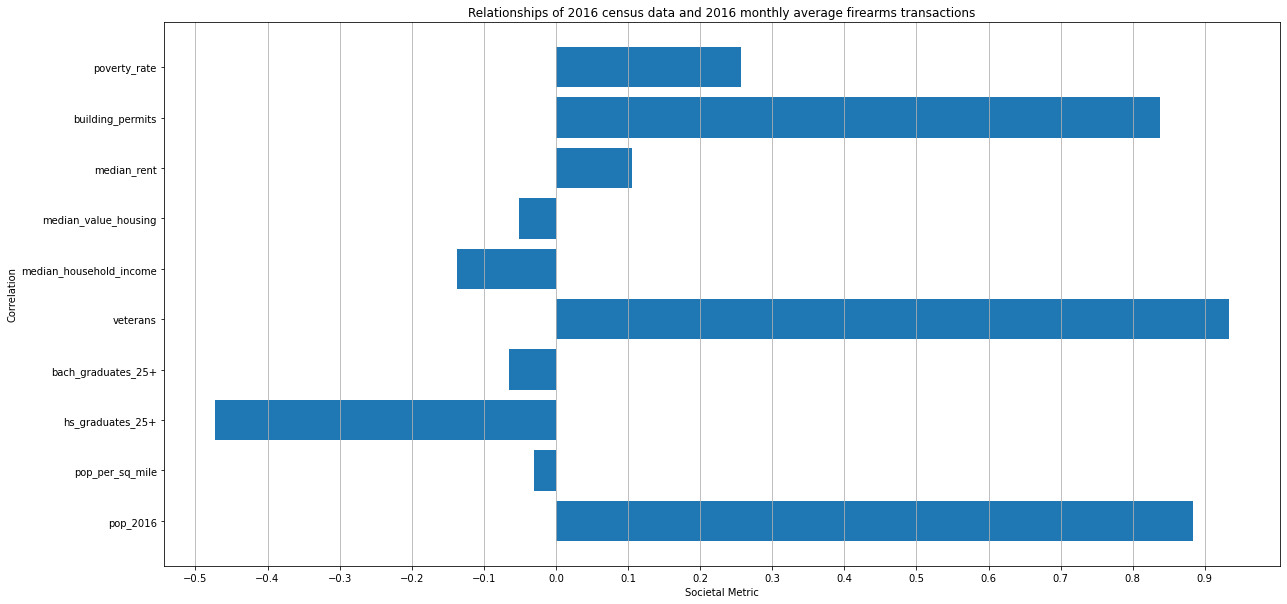

In [74]:
plt.figure(figsize=(20,10))
plt.barh(correlations_2016.index, correlations_2016.values)
plt.xlabel("Societal Metric")
plt.ylabel("Correlation")
plt.grid(axis = 'x')
plt.xticks(np.arange(-0.5, 1, step=0.1))
plt.title("Relationships of 2016 census data and 2016 monthly average firearms transactions");

These social metrics were chosen specifically to speak to certain state attributes:

- Raw Population
This serves as a sort of "baseline" by which the magnitude of other relationships can be judged - are they more or less closely related to firearms transactions than the population?

- Population Density 

I had expected population per square mile, as a measure of a state's population density and "ruralness", to have a significant positive correlation, rather than having virtually no relationship. I suspect that the above mention about "state culture" could be more at play here, having a stronger impact than population or measures stemming from population, such as this.

- Education

I was not surprised by the moderate negative relationship between high school graduates and firearms transactions, though I was surprised that 4-year college graduates had an insignificant relationship. I had suspected that an impact would be visible amongst high school graduation rates which would've become stronger with higher education and the diversity of thought and experience that is often attributed to a college education.

- Veteran Status

This metric was chosen in part because it would've been highly unlikely not to be a strong positive relationship. This is most certainly because of veterans being a group that self-selects into using and training with firearms far beyond most any member of the civilian population. Upon leaving the military, it stands to reason that they would be likely to drive sales of firearms and continue using skills that they built professionally. I would be very curious to investigate this further, with more robust data.

- Income

This was a metric that I thought could go either way in terms of its correlation, as I could see arguments for why increasing income would coincide with increased firearm transactions (firearms are expensive) or the reverse (higher income allows for a diversity of interests/hobbies). That it came back in the middle, without no significant relationship, seems to indicate that neither particular trend was particularly strong. A potential reason for this may be that where hobbies are concerned, many people prioritize their hobbies such that they will make it work with whatever disposable income they may have. 

- State Affluence/Economic Success

While I wasn't sure how strong of a relationship the metrics of median home value, median rent price, building permits, and poverty rate would have, I did figure that they would be relatively near to each other in magnitude, with poverty taking a reversed relationship relative to the other three. This did not end up being the case, as median home values and rents had no significant relationship with firearms transactions. 

The strength of the positive relationship between building permits and firearms transactions (0.84) was surprising. This metric was chosen as an indicator of growth or stagnation in a state, and it makes sense that growth would have a positive linear relationship with firearms transactions, even if I did not expect it to be so pronounced. After further consideration, this does make sense, as high rates of building and expansion in an area are generally indicative of a regional "boom", where more money is moving through the local economy and disposable income may increase, at least for a time. More building permits also lead to more job opportunities for blue-collar workers and laborers in particular, who might be more inclined than the overall population to make firearms transactions, especially with stabilized or increased income. This in particular might also speak to some of the "state culture" factors discussed elsewhere.

As mentioned, I had expected that the poverty rate would have a similar magnitude of relationship as the other measures of a state's affluence or economic success, but reflected into the negative because of its indication as a *lack* of economic success or regional affluence. I assumed this would be the case because higher poverty means less purchases happening because there is less money to spend. Two possible reasons occur to me which might explain the positive relationship seen here, though it is somewhat weak. First, people in poverty may be more likely to part with their property to try to make ends meet, pawning firearms or placing them as securities towards other debts, which would be a transaction collected in this dataset. Second, people in poverty are by definition unable to meet many of their own needs and may purchase firearms to try to satisfy their basic safety needs, especially if they are fearful of being preyed upon by others or become homeless. This would require much more detailed data to explore, though I'd be very interested to do so.

Of all the metrics studied in this report, the only census metric which had a stronger relationship with firearms transactions than raw population was veteran population. However, building permits had nearly as strong a relationship as raw population did, which was a surprise. The only other metric which had more than a weak relationship of any kind with firearms transactions was high school graduation rate, which had a moderate negative link with firearms transactions. As this relationship disappeared entirely with college graduation rate, I suspect that this relationship was actually driven by another factor which coincides with higher high school graduation. I'm unsure what that factor may be, as I would've initially guessed it to be some of the other factors which were shown in this study to have no meaningful relationship with firearms transactions, though I suspect it may come back to the mentioned concerns about the cultural values of different states, which this census data does not speak to.

<a id='references'></a>
## References

There were several resources used in putting together the python scripts for this project. Chief among them was the documentation for pandas, as this project used dataframes exclusively. Other references used for this project included:

[Stack Overflow](https://stackoverflow.com/questions/38572815/pandas-modify-string-values-in-each-cell)
For slicing strings inside the dataframe

[Stack Overflow](https://stackoverflow.com/questions/19960077/how-to-filter-pandas-dataframe-using-in-and-not-in-like-in-sql)
For NOT IN SQL behavior in a dataframe

[Stack Overflow](https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct)
For explaining how to use matplotlib's autopct for pie chart

[W3Schools MatPlotLib section](https://www.w3schools.com/python/matplotlib_intro.asp)
For several elements of putting together visualizations in matplotlib

[Kite](https://www.kite.com/python/answers/how-to-set-the-index-title-of-a-pandas-dataframe-in-python)
For setting the name of an existing index, rather than assigning a column to serve as an index